In [176]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from pathlib import PurePath
import cv2

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical


In [177]:
# root path
ROOT_DIR = os.getcwd()

# the origin_imgs path
DATA_PATH = os.path.join(ROOT_DIR, "origin_imgs")
TRAIN_IMG_PATH = os.path.join(ROOT_DIR, "train_imgs")

In [178]:
# image size and channel 
IMG_HEIGHT = 28
IMG_WIDTH = 28
IMG_CHANNEL = 1

# get the origin_imgs pic path
all_img_paths = glob.glob(os.path.join(DATA_PATH, "*.PNG"))

In [179]:
# TRAIN_IMG_PATH = "C:/Ipython/Keras_practice/0.1-poker-cards-dataset/train_imgs/"

# convert the channel and size of the picture
for img_path in all_img_paths:
    filename = (PurePath(img_path).stem) # get the origin images name, ex:c01
    new_filename = filename + ".png" # change the filename
    card_img_grey = cv2.imread(img_path, 0) # grayscale
    card_img = cv2.resize(card_img_grey, (IMG_HEIGHT, IMG_WIDTH))   
    
    path = os.path.join(TRAIN_IMG_PATH, new_filename).replace("\\","/") # to Windows style path
    cv2.imwrite(path, card_img) 


In [180]:
def show_image(image_path):
    # set the image size to show
    plt.figure(figsize=(8,8))

    # generate a 3*2 subplot
    for i in range(0, 6):
        img_file = 'h0'+str(i+1)+'.PNG'
        img = cv2.imread(os.path.join(image_path, img_file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(230+1+i) # (231) -> first subplot, (232) -> second subplot
        plt.title(img_file)  
        plt.axis('off')     
        plt.imshow(img)      
    plt.show()

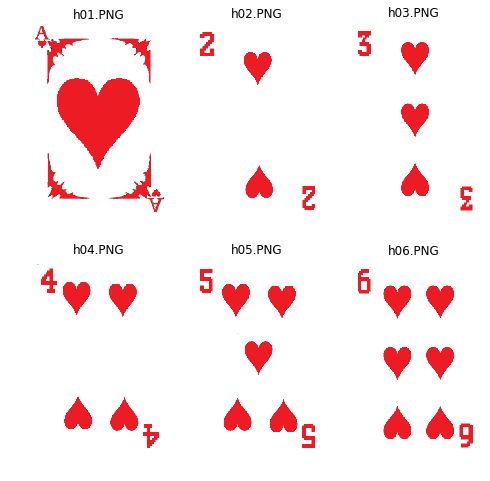

In [181]:
show_image(DATA_PATH)

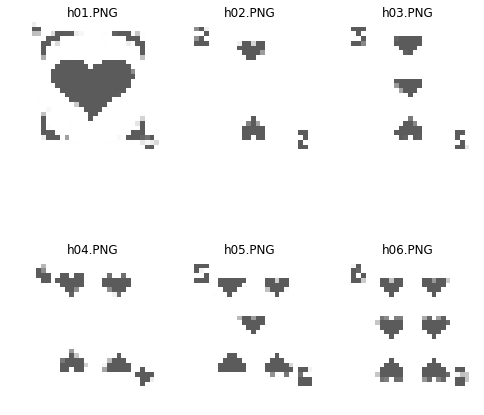

In [182]:
show_image(TRAIN_IMG_PATH)

In [183]:
num_classes = 52 
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL)
cards_data = pd.read_excel(os.path.join(ROOT_DIR, 'cards_data.xlsx'))

cards_data.head()

,image_id,image_path,card_type,card_num,card_color,card_label
0,c01,c01.png,club,1,black,club1
1,c02,c02.png,club,2,black,club2
2,c03,c03.png,club,3,black,club3
3,c04,c04.png,club,4,black,club4
4,c05,c05.png,club,5,black,club5


In [184]:
cards_label = cards_data['card_label']

# generate the dict
idx_to_label = {k:v for k, v in cards_label.iteritems()}
label_to_idx = {v:k for k, v in cards_label.iteritems()}

# get all the image label
y = np.array(cards_label.index.values)

# one-hot encoding
y_train = to_categorical(y, num_classes)
y_test = y_train.copy()

In [185]:
imgs = []
all_img_paths = glob.glob(os.path.join(TRAIN_IMG_PATH, "*.png"))

# turn type to float32 and normalization
for img_path in all_img_paths:
    img = cv2.imread(img_path,0) 
    img = img.astype('float32')/255.
    imgs.append(img)
    
X = np.array(imgs)    

# reshape to (num of image, image widthm image height, channel)
X_train = X.reshape(X.shape[0], 28, 28, 1)
X_test = X_train.copy()

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

X_train: (52, 28, 28, 1)
y_train: (52, 52)


In [186]:
def cnn_model():
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))    
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model;   

model = cnn_model() 
model.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 26, 26, 32)        9248      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 6, 6, 64)          0         
__________

In [187]:
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',
             optimizer="adam",
             metrics=['accuracy'])

In [188]:
# Data Augmentation
# Since we only have 52 images, using existing images to generate 
# new training images would be a good way to increase the size of the training data set.

datagen_train = ImageDataGenerator(rotation_range=3.)
datagen_train.fit(X_train)

In [189]:
batch_size = 100
steps_per_epoch = 1000
training_epochs = 10

# Through the "data generator" to generate training data, because the data is sustainable, 
# we can set the number of 'steps_per_epoch' to make the model have more training batches
history = model.fit_generator(datagen_train.flow(X_train, y_train, batch_size=batch_size),
                            steps_per_epoch= steps_per_epoch,
                            epochs=training_epochs)

Epoch 1/10
1000/1000 [==============================] - 22s - loss: 0.3363 - acc: 0.9054    
Epoch 2/10
1000/1000 [==============================] - 20s - loss: 0.0129 - acc: 0.9965    
Epoch 3/10
1000/1000 [==============================] - 22s - loss: 0.0071 - acc: 0.9983    
Epoch 4/10
1000/1000 [==============================] - 26s - loss: 0.0114 - acc: 0.9973    
Epoch 5/10
1000/1000 [==============================] - 26s - loss: 0.0074 - acc: 0.9985    
Epoch 6/10
1000/1000 [==============================] - 21s - loss: 0.0173 - acc: 0.9971    
Epoch 7/10
1000/1000 [==============================] - 19s - loss: 0.0116 - acc: 0.9986    
Epoch 8/10
1000/1000 [==============================] - 19s - loss: 0.0046 - acc: 0.9992    
Epoch 9/10
1000/1000 [==============================] - 19s - loss: 0.0580 - acc: 0.9950    
Epoch 10/10
1000/1000 [==============================] - 19s - loss: 0.0508 - acc: 0.9959    


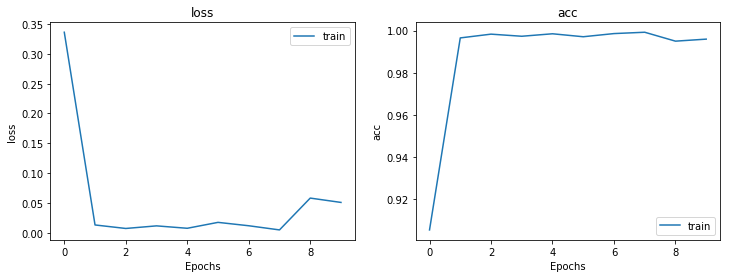

In [190]:
import matplotlib.pyplot as plt

def plot_train_history(history, train_metrics):
    plt.plot(history.history.get(train_metrics))
    plt.ylabel(train_metrics)
    plt.xlabel('Epochs')
    plt.legend(['train'])
    
    
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("loss")
plot_train_history(history, 'loss')

plt.subplot(1,2,2)
plt.title("acc")
plot_train_history(history, 'acc')

plt.show()

In [191]:
score = model.evaluate(X_test, y_test, verbose=1)

print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

32/52 [=================>............] - ETA: 0s
Test loss: 1.19209303762e-07
Test accuracy: 1.0


In [192]:
# upset the order of the images
randomize = np.arange(len(X_test))
np.random.shuffle(randomize)
X_test_randomize = X_test[randomize]
y_test_randomize = y_test[randomize]

In [193]:
score = model.evaluate(X_test_randomize, y_test_randomize, verbose=1)

print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

32/52 [=================>............] - ETA: 0s
Test loss: 1.19209303762e-07
Test accuracy: 1.0


In [194]:
print("[Info] Making prediction of X_test_randomize")  
prediction = model.predict_classes(X_test_randomize)  # Making prediction and save result to prediction  

print()
print()  
print("[Info] Show 52 prediction result (From 0):")  
print("%s\n" % (prediction[:52]))

[Info] Making prediction of X_test_randomize
32/52 [=================>............] - ETA: 0s

[Info] Show 52 prediction result (From 0):
[46 41  0  8 36 25 26  2 20 18 27 34 17 31 38 40 28  5 10 21 42 51 32 47  1
 24  9 43 11 35 39 45 50 29 12  4  6  3 14 15 30 23 49 48 37 16 19 44 13  7
 22 33]



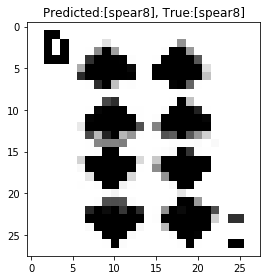

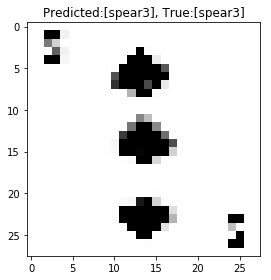

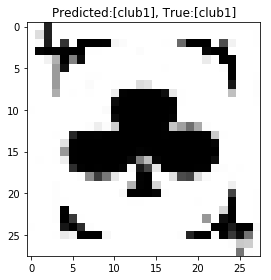

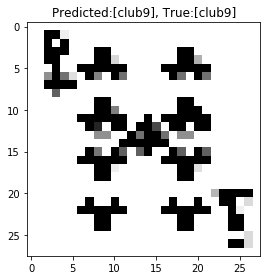

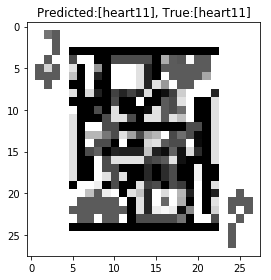

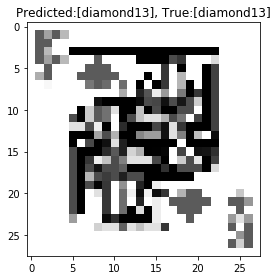

In [195]:
# Print out the image and forecast of each card
for i in range(X_test_randomize.shape[0]):
    true_class = idx_to_label.get(np.argmax(y_test_randomize[i]))
    predict_class = idx_to_label.get(prediction[i])
    plt.title("Predicted:[{}], True:[{}]".format(predict_class, true_class))
    plt.imshow(X_test_randomize[i].reshape(28,28), cmap=plt.get_cmap('gray'))
    plt.tight_layout()  
    plt.show()
    
    if i==5:
        break